In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [2]:
#convert the image to batches to solve memory error
path_csv = '/home/abhigith/Desktop/steel_defect_dataset/train.csv'   #complete path to csv data of images 
path_image_train = '/home/abhigith/Desktop/steel_defect_dataset/batch_images/'  #complete path to training images
data_csv = pd.read_csv(path_csv)

In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 1600
IMG_CHANNELS = 3

In [4]:
data_enc = data_csv['EncodedPixels']
data_img_id = list(data_csv['ImageId'])

In [5]:
data_enc.shape

(7095,)

In [6]:
train_img = next(os.walk(path_image_train))[2]    #walk through all images in the path
train_img.index('0a1cade03.jpg')                  #to get the index of an image id

11

In [21]:
x_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
img_with_mask = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [22]:
def rle2mask(rle, imgshape):
    #width & height of steel image
    width = imgshape[0]    
    height= imgshape[1]
    
    #flatttened empty array with size of input image
    mask= np.zeros( width*height ).astype(np.uint8)
    #convert all elements of encoded image pixels to int values
    array = np.asarray([int(x) for x in rle.split()])
    
    #splitting the encoded pixels
    #every odd index of encoded array is the start pixel &
    #every even index of encoded array is the length of the mask from start
    starts = array[0::2]
    lengths = array[1::2]
    
    #expanding the encoded pixel
    #current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 255
        #current_position += lengths[index]
    
    #numpy operations to bring the shape of mask suitable to image
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )


In [23]:
for i, img_id in tqdm(enumerate(train_img), total=len(train_img)):
    path = path_image_train + img_id
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = np.resize(img, (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    x_train[i] = img_resize     #store all the train images as numpy arrays for training
    
    #check whether an image has corresponding mask in the csv data or not
    if img_id in data_img_id:
        idx = data_img_id.index(img_id)
        img_resize_1 = np.resize(img, (IMG_HEIGHT,IMG_WIDTH,1))
        y_train[i] = rle2mask(data_enc[idx], img_resize_1.shape)   #store all the masks as numpy arrays for training
        

100%|██████████| 25/25 [00:00<00:00, 86.33it/s]


In [ ]:
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50

for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    img = cv2.imread( path_image_train+fn )
    mask = rle2mask( data_csv['EncodedPixels'].iloc[i], img.shape  )
    img[mask==1,0] = 255
    
    plt.imshow(img)
plt.show()

In [37]:
#convert numpy array to image
from PIL import Image
y = Image.fromarray(y_train[1])

In [38]:
x = cv2.imread(path_image_train+'0abfbfc69.jpg')

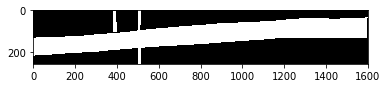

In [40]:
plt.imshow(y)